In [1]:
using LinearAlgebra
using Statistics
using Plots
using StatsPlots
using BenchmarkTools

In [2]:
# helper methods
function symmetric_matrix(dim::Integer, show_matrix::Bool=false)::Matrix{Float64}
    A = ones(dim,dim);
    for i = 1:dim
        for j = 1:i
            A[i,j] = rand(1:50);
            A[j,i] = A[i,j];
        end
    end
    if show_matrix
        display(A);
    end
    return A;
end

# we might change it to just rand(dim,dim)
function random_matrix(dim::Integer, show_matrix::Bool=false)::Matrix{Float64}
    A = ones(dim, dim);
    for i = 1:dim
        for j = 1:dim
            A[i,j] = rand(1:50);
        end
    end
    if show_matrix
        display(A);
    end
    return A
end

function diagonal_matrix(dim::Integer)::Matrix{Float64}
    Diag = ones(dim,dim)
    return Diagonal(Diag)
end

function eye(dim::Integer)::Matrix{Float64}
    return Matrix{Float64}(I,dim,dim);
end

function sparse_matrix(dim::Integer, show_matrix::Bool=false)::Matrix
    v = rand(dim)
    Diag = Matrix(Diagonal(v))
    for i=1:dim-1
        x = rand(1:dim);
        y = rand(1:dim);
        Diag[x,y] = rand(1)[1];
        Diag[y,x] = Diag[x,y];
    end
    return Diag
end


function custom_cond(λₘₐₓ, λₘᵢₙ)
    return sqrt(λₘₐₓ/λₘᵢₙ)
end

function get_diag(A::Matrix)::Array #get diagonal as vector
    dim = size(A,1)
    diag = Array{Float64}(undef, dim)
    for i=1:dim
        diag[i] = A[i,i]
    end
    return diag
end

function sort_eigens!(d::Array, V::Matrix)
    for i = 1:length(d)-1
        jMax = i
        for j = i+1:length(d)
            if d[j] > d[jMax]
                jMax=j
            end
        end
        if jMax != i
            swap!(d, i, jMax)
            swap!(V, i, jMax)
        end
    end
end

function swap!(d::Array, a::Integer, b::Integer)
    tmp = d[a]
    d[a] = d[b]
    d[b] = tmp
end

function swap!(V::Matrix, a::Integer, b::Integer)
    tmp = V[:,a]
    V[:,a] = V[:,b]
    V[:,b] = tmp
end

swap! (generic function with 2 methods)

# Metoda potęgowa

Poniżej przygotowana jest funkcja do metody iteracji prostej (metoda potęgowa), dzięki której można wyznaczyć największą co do modułu wartość własną, czyli promień spektralny macierzy, który opisany jest wzorem:
## $$\rho(A) = |\lambda_{max}| = \lim_{i \to \infty} \frac{||t_{i+1}||_{\infty}}{||t_{i}||_{\infty}}$$

Przy założeniu, że dowolny wektor początkowy t_{0} != 0, do uzyskania promienia spektralnego prowadzą iteracje postaci:
## $$t_{i+1} = At_{i},\ i=0,1,2...$$



In [3]:
function power_eigen(A::Matrix, iterations::Integer)::Tuple{Array, Array}
    n = size(A, 1);
    x = ones(n,1);
    results = Float64[];
    eig = nothing;
    x1 = x;
    
    for i = 1:iterations
        x1 = x;
        x = A * x;
        x = x / norm(x);
        eig = x' * A * x1 / (x' * x1);
        push!(results, eig[1]);
    end
    return eig, results;
end

function power_eigen_min(A::Matrix, iterations::Integer)::Array
    n = size(A, 1);
    x = ones(n,1);
    x1 = x;
    for i = 1:iterations
        x1 = x;
        x = A \ x;
        x = x / norm(x);
    end

    return x' * A * x1 / (x' * x1);
end

function power_eigen_stop(A::Matrix, max_iterations::Integer=9999, error::Float64=1e-5)::Tuple{Array, Array}
    n = size(A, 1);
    x = ones(n,1);
    x1 = x;
    eig = nothing
    
    for i = 1:max_iterations
        x1 = x;
        x = A * x;
        x = x / norm(x);
        
        new_eig = x' * A * x1 / (x' * x1)

        if eig != nothing && abs(new_eig[1] - eig) < error
            return new_eig, x
        end
        eig = new_eig[1]
    end
    return eig, x
end

power_eigen_stop (generic function with 3 methods)

In [4]:
A = symmetric_matrix(5);
#A = random_matrix(5);
#A = [22 21 -8 4; 21 49 11 39; -8 11 60 -19; 4 39 -19 135]
λₘₐₓ, _ = power_eigen(A, 20);
λₘᵢₙ = power_eigen_min(A,20);
display(λₘₐₓ);
display(λₘᵢₙ);
e, v = eigen(A);
display(e);
display(v)
e, v = power_eigen_stop(A)
display(e)
display(v)

1×1 Array{Float64,2}:
 110.72104716449108

1×1 Array{Float64,2}:
 -16.354712445616492

5-element Array{Float64,1}:
 -21.94799098740289
 -16.35465742492989
  27.731780174607035
  37.84982107323455
 110.72104716449094

5×5 Array{Float64,2}:
  0.449645    0.353109  -0.635503  -0.145226  0.498174
  0.0810637   0.352271   0.719548  -0.31241   0.50397
 -0.734533    0.410392  -0.148941   0.420705  0.304735
 -0.312706   -0.711641  -0.123596  -0.289918  0.544476
  0.392332   -0.276342   0.202306   0.787568  0.329423

1×1 Array{Float64,2}:
 110.72104712582106

5×1 Array{Float64,2}:
 0.49817249577543193
 0.5039653748301006
 0.30474058182340447
 0.5444720597042153
 0.32943348253724253

In [5]:
# benchmark time for above Matrix
@btime  power_eigen(A, 20); # λₘₐₓ
@btime  power_eigen_min(A,20); # λₘᵢₙ

  20.201 μs (168 allocations: 17.67 KiB)
  16.201 μs (87 allocations: 13.84 KiB)


Jak widać z wyniku wykonania powyższego kodu, uzyskaliśmy największą co do modułu wartość własną macierzy. Ta wartość zgadza się z wartością otrzymaną za pomocą metody eigen(A). Za pomocą metody potęgowej można również wyznaczyć najmniejszą co do modułu wartość własną macierzy. Korzysta się z twierdzenia dotyczącego przesunięcia spektrum macierzy:<br />
### "Jeżeli $\lambda$ jest wartością własną macierzy A, to $\lambda + r$ jest wartością własną macierzy $A + \tau I$"
Należy pamiętać, że twierdzenie ma zastosowanie dla macierzy symetrycznych i dodatnio określonych. Po zastosowaniu przesunięcia $B = A - \lambda_{max}I$ można ponownie zastosować metodę iteracji prostej dla macierzy B zbieżną do największej co do modułu wartości własnej $\lambda = \lambda_{min}-\lambda_{max}$. Stąd można wyznaczyć $\lambda_{min}$.

In [6]:
B = A' * A;
λₘₐₓ, _ = power_eigen(B, 50);
n = size(A,1);
B_min = B - λₘₐₓ .* eye(n);
lambda_dash, _ = power_eigen(B_min, 50);
λₘᵢₙ = lambda_dash + λₘₐₓ;

Mając największą i najmniejszą wartość własną macierzy, można wyznaczyć współczynnik uwarunkowania macierzy:
$$cond(A)=\sqrt{\frac{\lambda_{max}(A^TA)}{\lambda_{min}(A^TA)}}$$
We wzorze przyjęto, że macierz A jest symetryczna, co oznacza, że $A=A^T$, ewentualnie można macierz wejściową doprowadzić do postaci symetrycznej stosując wzór $B = A^TA$

In [7]:
value = custom_cond(λₘₐₓ, λₘᵢₙ)
print(value)

cond(A)

[6.420626938031666]

6.770001002632786

# Metoda Jacobiego

In [4]:
function jacobi_eigen(A::Matrix, iterations::Integer)::Tuple{Matrix{Float64}, Array}
    n = size(A,1);
    results = Float64[];
    for i = 1:iterations
        s,t = maxst(A);
        
        d = √((A[s,s] - A[t,t])^2 + 4 * A[s,t]^2);
        sin2t = 2 * A[s,t] / d;
        cos2t = (A[s,s] - A[t,t]) / d;
        dt = sqrt(2 * (1 + cos2t));
        sint = abs(sin2t) / dt;
        cost = abs((1 + cos2t) / dt);
        cost = sign(A[s,t]) * cost;

        R = eye(n);
        R[s,s] = cost;
        R[t,t] = cost;
        R[s,t] = -sint;
        R[t,s] = sint;
        
        A = R' * A * R; 
        DA = Diagonal(A);
        val = maximum(abs, DA);
        push!(results, val);
        
    end
    return A, results
end

function jacobi_eigen_stop(A::Matrix, max_iterations::Integer=9999, error::Float64=1e-5)::Tuple{Array, Matrix{Float64}}
    n = size(A,1);
    eigs = nothing
    eigenVectors = eye(n)
    for i = 1:max_iterations
        s,t = maxst(A);
        
        d = √((A[s,s] - A[t,t])^2 + 4 * A[s,t]^2);
        sin2t = 2 * A[s,t] / d;
        cos2t = (A[s,s] - A[t,t]) / d;
        dt = sqrt(2 * (1 + cos2t));
        sint = abs(sin2t) / dt;
        cost = abs((1 + cos2t) / dt);
        cost = sign(A[s,t]) * cost;

        R = eye(n);
        R[s,s] = cost;
        R[t,t] = cost;
        R[s,t] = -sint;
        R[t,s] = sint;
        
        A = R' * A * R;
        
        new_eigs = get_diag(A)
        eigenVectors = eigenVectors*R
        if eigs != nothing && norm(new_eigs - eigs) < error
            return new_eigs, eigenVectors
        end
        eigs = new_eigs
        
    end
    return eigs, eigenVectors
end

function maxst(A::Matrix)::Tuple{Integer,Integer}
    s = 1;
    t = 2;
    n = size(A,1);
    for c = 2:n
        for r = 1:c-1
            if abs(A[r,c]) > abs(A[s,t])
                s = r;
                t = c;
            end
        end
    end
    return s, t
end

maxst (generic function with 1 method)

In [132]:
#F = [12 6 -6 1; 6 16 2 100; -6 2 16 1 ;1 100 1 4];
#F = rand(4,4);
F = symmetric_matrix(10,true);
FJ, _ = jacobi_eigen(F, 15);

n = size(FJ,1);
FJ = Diagonal(FJ);

#display(FJ)
e,v = eigen(F);
display(e)
display(v)
e,v = jacobi_eigen_stop(F)
display(e)
display(v)

10×10 Array{Float64,2}:
  6.0  45.0  18.0   2.0   5.0  50.0  34.0  23.0  47.0  43.0
 45.0  42.0  50.0  32.0  37.0  34.0  26.0  12.0  36.0   7.0
 18.0  50.0  36.0  34.0  16.0  42.0  21.0  46.0  47.0  26.0
  2.0  32.0  34.0  36.0  44.0  49.0   9.0  17.0  13.0  11.0
  5.0  37.0  16.0  44.0  29.0  28.0  21.0   3.0  21.0  16.0
 50.0  34.0  42.0  49.0  28.0  35.0  47.0  30.0  30.0  16.0
 34.0  26.0  21.0   9.0  21.0  47.0  17.0  40.0  49.0  10.0
 23.0  12.0  46.0  17.0   3.0  30.0  40.0  44.0  19.0  15.0
 47.0  36.0  47.0  13.0  21.0  30.0  49.0  19.0  16.0  44.0
 43.0   7.0  26.0  11.0  16.0  16.0  10.0  15.0  44.0  37.0

10-element Array{Float64,1}:
 -66.51300405691991
 -48.82147222663407
 -31.158675454346493
 -13.871540109572962
   2.369318568328495
  20.434738163581642
  26.54751382629432
  47.034884861175456
  71.39706431067881
 290.58117211741455

10×10 Array{Float64,2}:
 -0.609463  -0.359241     0.0138543  …   0.219944   -0.306963   -0.30884
  0.28911    0.248219     0.161001       0.193779    0.228976   -0.358159
 -0.347012   0.0985943   -0.358643      -0.213306    0.0178019  -0.372991
 -0.168415  -0.0287578    0.594472      -0.0747481   0.570821   -0.271687
 -0.115199  -0.184979    -0.408349       0.259325    0.463312   -0.237914
  0.391065   0.00950243  -0.438955   …  -0.135787    0.118363   -0.392857
 -0.233749   0.547688     0.210637      -0.164892   -0.18484    -0.307806
  0.166669  -0.1778       0.0648801     -0.688353   -0.246003   -0.276859
  0.356578  -0.521647     0.289063       0.233568   -0.262483   -0.350418
  0.142902   0.400983    -0.0172936      0.470879   -0.367345   -0.241403

10-element Array{Float64,1}:
 290.5811601853555
  71.39707018384718
  47.03479313822534
  26.547578332660983
  20.434733875042134
   2.369290992121897
 -13.87152975493098
 -31.158642924798038
 -48.8214650501
 -66.5129889774243

10×10 Array{Float64,2}:
 0.308948   0.306947    0.220042   …   0.0134444  -0.359369   -0.609529
 0.358141  -0.228956    0.194568       0.160832    0.248167    0.289152
 0.372968  -0.0179004  -0.213652      -0.358535    0.0986628  -0.346826
 0.271591  -0.570932   -0.0753796      0.594266   -0.0287167  -0.168446
 0.23779   -0.463373    0.258809      -0.407841   -0.185016   -0.115335
 0.392875  -0.118432   -0.135257   …  -0.439396    0.0095494   0.391004
 0.307798   0.184883   -0.164237       0.211063    0.54774    -0.233801
 0.276834   0.245927   -0.689007       0.0649294  -0.177648    0.166899
 0.35046    0.262367    0.233689       0.289455   -0.521674    0.356544
 0.241507   0.367205    0.469898      -0.0174019   0.400831    0.142744

99

In [10]:
# benchmark time for above Matrix
@btime jacobi_eigen(F, 15);

  20.299 μs (65 allocations: 42.09 KiB)


# QR algorithm

In [5]:
function QR_eigen(A::Matrix, iterations::Integer)::Tuple{Matrix{Float64}, Array}
    results = Float64[];
    n = size(A,1);
    Q = zeros(n,n);
    R = zeros(n,n);
    for k = 1:iterations
        mgs!(Q, R, A);
        A = R * Q;
        DA = Diagonal(A);
        val = maximum(abs, DA);
        push!(results, val);
    end
    return A, results;
end

function QR_eigen_stop(A::Matrix, max_iterations::Integer=9999, error::Float64=1e-5)::Tuple{Array, Matrix{Float64}}
    eigs = nothing
    n = size(A,1);
    pQ = eye(n);
    Q = zeros(n,n);
    R = zeros(n,n);
    for k = 1:max_iterations
        mgs!(Q, R, A);
        A = R * Q ;
        pQ = pQ * Q
        new_eigs = get_diag(A)
        if eigs != nothing && norm(new_eigs - eigs) < error #!any(broadcast(abs, new_eigs .- eigs) .> error) #norm(new_eigs - eigs) < error
            return new_eigs, pQ
        end
        eigs = new_eigs
    end
    return eigs, pQ;
end

function mgs!(Q::Matrix, R::Matrix, A::Matrix)
    n = size(A,1);
    for j = 1:n
        v = A[:,j];
        for i = 1:j-1
            R[i,j] = Q[:,i]' * v;
            v = v - R[i,j] * Q[:,i];
        end
        R[j,j] = norm(v);
        Q[:,j] = v / R[j,j];
    end
end


mgs! (generic function with 1 method)

In [11]:
A = symmetric_matrix(5);
AQR, _ = QR_eigen(A, 30);
Diag = Diagonal(AQR);
display(Diag);

e, v = eigen(A);
display(e)
display(v)
e, v = QR_eigen_stop(A, 9999, 1e-9);
display(e)
display(v)
sort_eigens!(e,v)
display(e)
display(v)

5×5 Diagonal{Float64,Array{Float64,1}}:
 168.016     ⋅         ⋅        ⋅        ⋅ 
    ⋅     -38.7181     ⋅        ⋅        ⋅ 
    ⋅        ⋅      -39.4405    ⋅        ⋅ 
    ⋅        ⋅         ⋅      13.3044    ⋅ 
    ⋅        ⋅         ⋅        ⋅      -4.16214

5-element Array{Float64,1}:
 -40.62745555827571
 -37.531175584022115
  -4.16213791531144
  13.304432345749667
 168.01633671185945

5×5 Array{Float64,2}:
 -0.232085  -0.433733    0.365773  -0.728351   -0.30615
 -0.298281   0.15231     0.628666   0.518767   -0.472746
 -0.666018   0.0486167  -0.637094   0.0247887  -0.384127
  0.438669  -0.672148   -0.231663   0.329171   -0.440188
  0.470271   0.578386   -0.106924  -0.302353   -0.58435

5-element Array{Float64,1}:
 168.01633671185948
 -40.62745555270176
 -37.53117558959602
  13.304432345749728
  -4.162137915311409

5×5 Array{Float64,2}:
 0.30615   -0.232103  -0.433723   -0.728351   -0.365773
 0.472746  -0.298274   0.152323    0.518767   -0.628666
 0.384127  -0.666016   0.0486449   0.0247887   0.637094
 0.440188   0.43864   -0.672167    0.329171    0.231663
 0.58435    0.470296   0.578366   -0.302353    0.106924

5-element Array{Float64,1}:
 168.01633671185948
  13.304432345749728
  -4.162137915311409
 -37.53117558959602
 -40.62745555270176

5×5 Array{Float64,2}:
 0.30615   -0.728351   -0.365773  -0.433723   -0.232103
 0.472746   0.518767   -0.628666   0.152323   -0.298274
 0.384127   0.0247887   0.637094   0.0486449  -0.666016
 0.440188   0.329171    0.231663  -0.672167    0.43864
 0.58435   -0.302353    0.106924   0.578366    0.470296

In [12]:
A = symmetric_matrix(100);
@benchmark QR_eigen_stop($A)

BenchmarkTools.Trial: 
  memory estimate:  16.84 GiB
  allocs estimate:  20010002
  --------------
  minimum time:     3.601 s (10.59% GC)
  median time:      3.606 s (10.56% GC)
  mean time:        3.606 s (10.56% GC)
  maximum time:     3.611 s (10.54% GC)
  --------------
  samples:          2
  evals/sample:     1

# Badania

Poniższe wykresy prezentują zbieżność tylko dla największych wartości własnych, ponieważ metoda potęgowa wyznacza tylko pojedynczą wartość.

In [6]:
function plot_eigenvalues(PlotA::Matrix, max_iterations::Integer, show_all_in_one::Bool=false, err::Bool=false)
    x = 1:max_iterations;
    e, v = eigen(PlotA);
    eigen_lambda = maximum(abs, e);
    if !err
        results_eig = zeros(0);
        for i = x
            append!(results_eig, eigen_lambda);
        end
    end

    #power method
    _, results_power = power_eigen(PlotA, max_iterations);
    if err
        results_power = broadcast(abs, results_power .- eigen_lambda);
        #results_power = abs.(results_power - eigen_lambda);
    end

    # jacobi algorithm
    _, results_jacobi = jacobi_eigen(PlotA, max_iterations);
    if err
        results_jacobi = broadcast(abs, results_jacobi .- eigen_lambda);
    end

    # QR algorithm
    _, results_qr = QR_eigen(PlotA, max_iterations);
    if err
        results_qr = broadcast(abs, results_qr .- eigen_lambda);
    end


    if err
        results = hcat(results_power, results_jacobi, results_qr);
        plot_all = plot(x, results, title= "Lambda max error", label=["power" "jacobi" "QR"], xlabel="iteracje", ylabel="błąd lambda");
        results = results_power;
        plot_power = plot(x, results, title= "Lambda max error", label="power", xlabel="iteracje", ylabel="błąd lambda");
        results = results_jacobi;
        plot_jacobi = plot(x, results, title= "Lambda max error", label="jacobi", xlabel="iteracje", ylabel="błąd lambda");
        results = results_qr;
        plot_qr = plot(x, results, title= "Lambda max error", label="QR", xlabel="iteracje", ylabel="błąd lambda");
    else
        results = hcat(results_eig, results_power, results_jacobi, results_qr);
        plot_all = plot(x, results, title= "Lambda max", label=["eigen" "power" "jacobi" "QR"], xlabel="iteracje", ylabel="wartosc lambda", ylim=(eigen_lambda*0.25, eigen_lambda*1.2));
        results = hcat(results_eig, results_power);
        plot_power = plot(x, results, title= "Lambda max", label=["eigen" "power"], xlabel="iteracje", ylabel="wartosc lambda");
        results = hcat(results_eig, results_jacobi);
        plot_jacobi = plot(x, results, title= "Lambda max", label=["eigen" "jacobi"], xlabel="iteracje", ylabel="wartosc lambda");
        results = hcat(results_eig, results_qr);
        plot_qr = plot(x, results, title= "Lambda max", label=["eigen" "QR"], xlabel="iteracje", ylabel="wartosc lambda");
    end
    if !show_all_in_one
        #show plots separate 
        display(plot_all);
        display(plot_power);
        display(plot_jacobi);
        display(plot_qr);
    else
        # all plots together
        all_plots = plot(plot_all, plot_power, plot_jacobi, plot_qr, size = (800,800), layout = grid(4, 1, heights=[0.25 , 0.25, 0.25, 0.25]));
        display(all_plots);
        png("lambda_error");
    end

end

plot_eigenvalues (generic function with 3 methods)

In [9]:
# plot time benchmarks
#plot for [x1, x2, x3...] iterations
# plot_mean_time(A, [5, 10]);
function plot_mean_time(A::Matrix, iterations::Array, sample::Integer=2000)

    n = size(iterations,1);
    results = zeros(1);
    nam = [];

    for i = 1:n
        power = @benchmark  power_eigen(A, $iterations[$i]) samples = sample;
        power = mean(power.times)/1000;
        jacobi = @benchmark jacobi_eigen(A, $iterations[$i]) samples = sample;
        jacobi = mean(jacobi.times)/1000;
        qr = @benchmark QR_eigen(A, $iterations[$i]) samples = sample;
        qr = mean(qr.times)/1000;
        results = hcat(results, power, jacobi, qr);
        push!(nam, iterations[i]);
        push!(nam, iterations[i]);
        push!(nam, iterations[i]);
    end
    results = results[2:end];
    ctg = repeat(["Power", "Jacobi", "QR"], outer = n)
    
    plot_time = groupedbar(nam, results, group = ctg, xlabel = "Liczba iteracji", ylabel = "Średni czas [µs]",
        title = "Czas wykonania metod dla określonej liczby iteracji", bar_width = 0.67,
        lw = 0, framestyle = :box)
    display(plot_time);
    png("time_number_iter");
    
end

# plot to reach stop condition
function plot_mean_time(A::Matrix, sample::Integer=5000)
    power = @benchmark  power_eigen_stop(A) samples = sample;
    power = mean(power.times)/1000;
    jacobi = @benchmark jacobi_eigen_stop(A) samples = sample;
    jacobi = mean(jacobi.times)/1000;
    qr = @benchmark QR_eigen_stop(A) samples = sample;
    qr = mean(qr.times)/1000;

    results = [power, jacobi, qr];
    nam = repeat(["time"], inner=3);
    ctg = repeat(["Power", "Jacobi", "QR"], outer = 1)

    display(results);

    plot_time = groupedbar(nam, results, group = ctg, ylabel = "Średni czas [µs]",
        title = "Czas wykonania metod do warunku stopu", bar_width = 0.67,
        lw = 0, framestyle = :box);
    display(plot_time);
    png("time_stop_cond");
end

plot_mean_time (generic function with 4 methods)

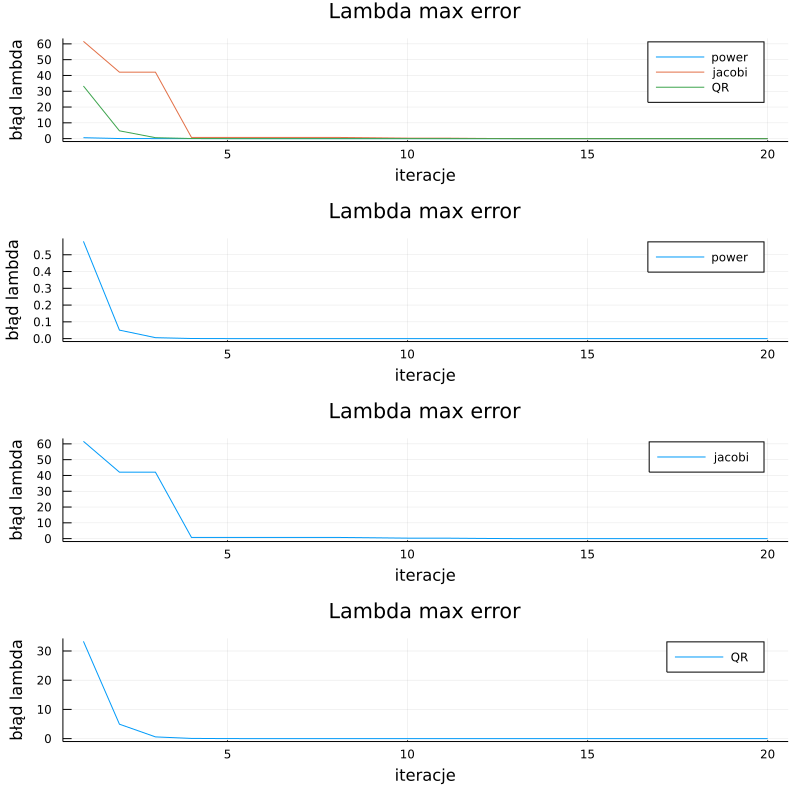

In [61]:
A = symmetric_matrix(5);
plot_eigenvalues(A, 20, true, true);

3-element Array{Float64,1}:
  10.2021955
  28.5330864
 605.8399786

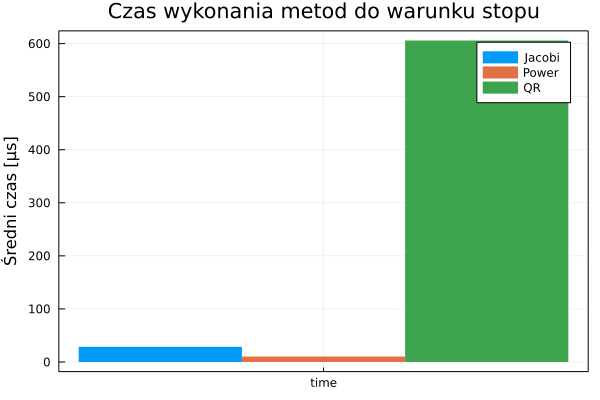

In [62]:
plot_mean_time(A);

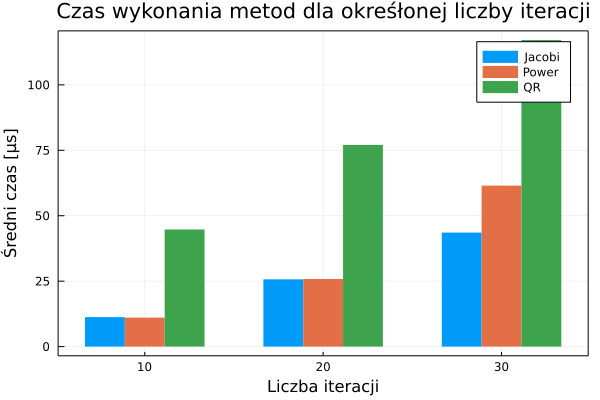

In [59]:
plot_mean_time(A, [10, 20, 30]);

## Przypadki testowe

metoda potęgowa - macierze o elementach i wartościach własnych rzeczywistych<br />
metoda Jacobiego - macierze symetryczne (w tym hermitowskie)<br />
algorytm QR - macierze symetryczne/niesymetryczne

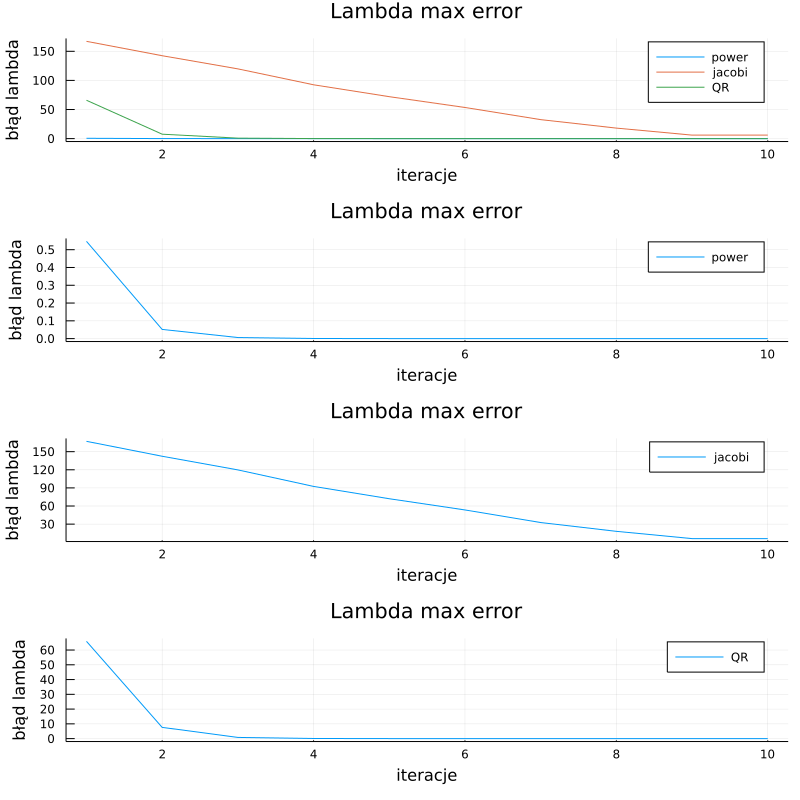

In [40]:
Test1 = symmetric_matrix(10)
plot_eigenvalues(Test1, 10, true, true)

Benchmarki dla wszystkich metod przy różnych rozmiarach macierzy:

In [41]:
A = symmetric_matrix(5)
print("Power: ")
a = @benchmark power_eigen_stop(A);
display(a)
print("Jacobi: ")
b = @benchmark jacobi_eigen_stop(A);
display(b)
print("QR: ")
c = @benchmark QR_eigen_stop(A);
display(c)

BenchmarkTools.Trial: 
  memory estimate:  5.22 KiB
  allocs estimate:  50
  --------------
  minimum time:     6.120 μs (0.00% GC)
  median time:      6.860 μs (0.00% GC)
  mean time:        7.882 μs (7.01% GC)
  maximum time:     1.147 ms (98.91% GC)
  --------------
  samples:          10000
  evals/sample:     5

Power: 

BenchmarkTools.Trial: 
  memory estimate:  31.81 KiB
  allocs estimate:  139
  --------------
  minimum time:     21.800 μs (0.00% GC)
  median time:      22.800 μs (0.00% GC)
  mean time:        27.601 μs (4.40% GC)
  maximum time:     2.749 ms (98.21% GC)
  --------------
  samples:          10000
  evals/sample:     1

Jacobi: 

BenchmarkTools.Trial: 
  memory estimate:  184.38 KiB
  allocs estimate:  1407
  --------------
  minimum time:     78.901 μs (0.00% GC)
  median time:      82.699 μs (0.00% GC)
  mean time:        100.418 μs (7.32% GC)
  maximum time:     3.325 ms (96.79% GC)
  --------------
  samples:          10000
  evals/sample:     1

QR: 

In [15]:
A = symmetric_matrix(10)
print("Power: ")
a = @benchmark power_eigen_stop(A);
display(a)
print("Jacobi: ")
b = @benchmark jacobi_eigen_stop(A);
display(b)
print("QR: ")
c = @benchmark QR_eigen_stop(A);
display(c)

BenchmarkTools.Trial: 
  memory estimate:  5.81 KiB
  allocs estimate:  50
  --------------
  minimum time:     7.725 μs (0.00% GC)
  median time:      8.250 μs (0.00% GC)
  mean time:        9.836 μs (5.59% GC)
  maximum time:     1.413 ms (98.82% GC)
  --------------
  samples:          10000
  evals/sample:     4

BenchmarkTools.Trial: 
  memory estimate:  366.75 KiB
  allocs estimate:  577
  --------------
  minimum time:     144.200 μs (0.00% GC)
  median time:      148.000 μs (0.00% GC)
  mean time:        175.659 μs (7.76% GC)
  maximum time:     2.455 ms (89.23% GC)
  --------------
  samples:          10000
  evals/sample:     1

Power: 

BenchmarkTools.Trial: 
  memory estimate:  10.45 MiB
  allocs estimate:  65487
  --------------
  minimum time:     3.706 ms (0.00% GC)
  median time:      3.753 ms (0.00% GC)
  mean time:        4.403 ms (8.63% GC)
  maximum time:     10.010 ms (0.00% GC)
  --------------
  samples:          1132
  evals/sample:     1

Jacobi: QR: 

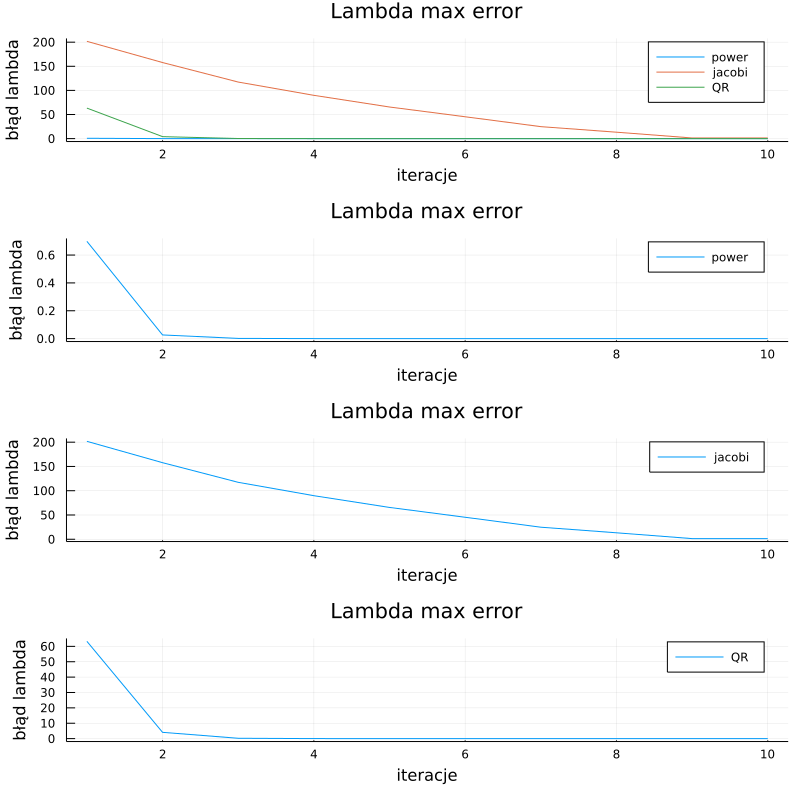

In [16]:
plot_eigenvalues(A, 10, true, true);

3-element Array{Float64,1}:
    9.4382912
  181.6480134
 4592.375141404806

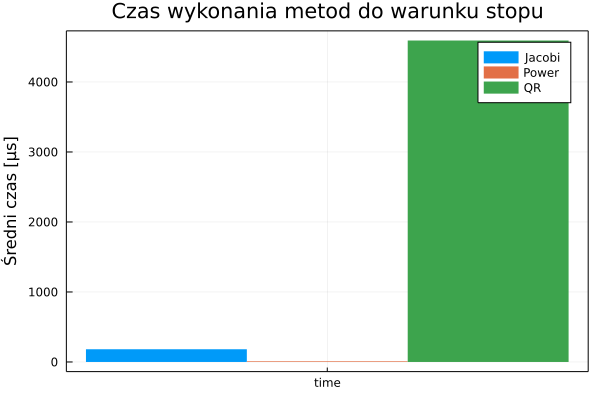

In [17]:
plot_mean_time(A);

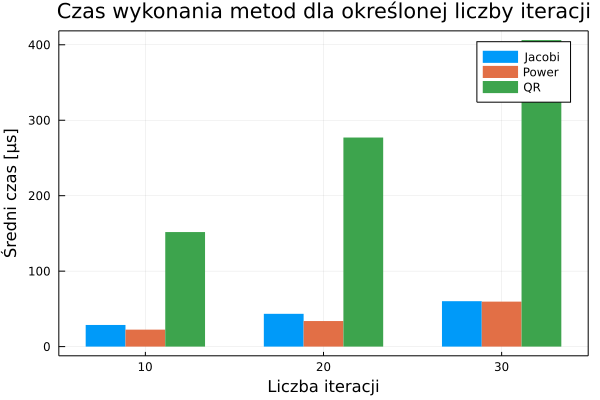

In [18]:
plot_mean_time(A, [10, 20, 30]);

In [47]:
A = symmetric_matrix(25)
print("Power: ")
a = @benchmark power_eigen_stop(A);
display(a)
print("Jacobi: ")
b = @benchmark jacobi_eigen_stop(A);
display(b)
print("QR: ")
c = @benchmark QR_eigen_stop(A);
display(c)

BenchmarkTools.Trial: 
  memory estimate:  6.88 KiB
  allocs estimate:  42
  --------------
  minimum time:     9.999 μs (0.00% GC)
  median time:      12.299 μs (0.00% GC)
  mean time:        14.328 μs (3.70% GC)
  maximum time:     5.332 ms (99.29% GC)
  --------------
  samples:          10000
  evals/sample:     1

Power: 

BenchmarkTools.Trial: 
  memory estimate:  12.99 MiB
  allocs estimate:  3835
  --------------
  minimum time:     5.621 ms (0.00% GC)
  median time:      6.237 ms (0.00% GC)
  mean time:        7.426 ms (11.77% GC)
  maximum time:     18.151 ms (52.31% GC)
  --------------
  samples:          671
  evals/sample:     1

Jacobi: 

BenchmarkTools.Trial: 
  memory estimate:  708.95 MiB
  allocs estimate:  2513019
  --------------
  minimum time:     400.836 ms (10.42% GC)
  median time:      422.518 ms (11.13% GC)
  mean time:        423.822 ms (10.88% GC)
  maximum time:     467.065 ms (9.92% GC)
  --------------
  samples:          12
  evals/sample:     1

QR: 

In [48]:
A = symmetric_matrix(50)
print("Power: ")
a = @benchmark power_eigen_stop(A);
display(a)
print("Jacobi: ")
b = @benchmark jacobi_eigen_stop(A);
display(b)
print("QR: ")
c = @benchmark QR_eigen_stop(A);
display(c)

BenchmarkTools.Trial: 
  memory estimate:  10.13 KiB
  allocs estimate:  42
  --------------
  minimum time:     23.600 μs (0.00% GC)
  median time:      27.100 μs (0.00% GC)
  mean time:        34.768 μs (1.19% GC)
  maximum time:     4.208 ms (98.60% GC)
  --------------
  samples:          10000
  evals/sample:     1

Power: 

BenchmarkTools.Trial: 
  memory estimate:  195.66 MiB
  allocs estimate:  25192
  --------------
  minimum time:     184.209 ms (11.02% GC)
  median time:      211.444 ms (10.58% GC)
  mean time:        212.994 ms (10.84% GC)
  maximum time:     260.733 ms (10.11% GC)
  --------------
  samples:          24
  evals/sample:     1

Jacobi: 

BenchmarkTools.Trial: 
  memory estimate:  15.56 GiB
  allocs estimate:  33164756
  --------------
  minimum time:     12.605 s (10.86% GC)
  median time:      12.605 s (10.86% GC)
  mean time:        12.605 s (10.86% GC)
  maximum time:     12.605 s (10.86% GC)
  --------------
  samples:          1
  evals/sample:     1

QR: 

In [49]:
A = symmetric_matrix(100)
print("Power: ")
a = @benchmark power_eigen_stop(A);
display(a)
print("Jacobi: ")
b = @benchmark jacobi_eigen_stop(A);
display(b)
print("QR: ")
c = @benchmark QR_eigen_stop(A);
display(c)

BenchmarkTools.Trial: 
  memory estimate:  13.28 KiB
  allocs estimate:  34
  --------------
  minimum time:     59.900 μs (0.00% GC)
  median time:      68.100 μs (0.00% GC)
  mean time:        74.256 μs (1.49% GC)
  maximum time:     5.767 ms (98.62% GC)
  --------------
  samples:          10000
  evals/sample:     1

Power: 

BenchmarkTools.Trial: 
  memory estimate:  2.90 GiB
  allocs estimate:  96722
  --------------
  minimum time:     3.109 s (6.45% GC)
  median time:      3.160 s (6.33% GC)
  mean time:        3.160 s (6.33% GC)
  maximum time:     3.212 s (6.21% GC)
  --------------
  samples:          2
  evals/sample:     1

Jacobi: 

BenchmarkTools.Trial: 
  memory estimate:  69.10 GiB
  allocs estimate:  82084624
  --------------
  minimum time:     43.033 s (14.08% GC)
  median time:      43.033 s (14.08% GC)
  mean time:        43.033 s (14.08% GC)
  maximum time:     43.033 s (14.08% GC)
  --------------
  samples:          1
  evals/sample:     1

QR: 

In [82]:
A = sparse_matrix(25)
print("Power: ")
a = @benchmark power_eigen_stop(A);
display(a)
print("Jacobi: ")
b = @benchmark jacobi_eigen_stop(A);
display(b)
print("QR: ")
c = @benchmark QR_eigen_stop(A);
display(c)

BenchmarkTools.Trial: 
  memory estimate:  20.00 KiB
  allocs estimate:  122
  --------------
  minimum time:     29.600 μs (0.00% GC)
  median time:      31.101 μs (0.00% GC)
  mean time:        36.544 μs (4.39% GC)
  maximum time:     5.471 ms (98.92% GC)
  --------------
  samples:          10000
  evals/sample:     1

Power: 

BenchmarkTools.Trial: 
  memory estimate:  5.55 MiB
  allocs estimate:  1639
  --------------
  minimum time:     2.316 ms (0.00% GC)
  median time:      2.986 ms (0.00% GC)
  mean time:        4.054 ms (12.93% GC)
  maximum time:     20.105 ms (45.37% GC)
  --------------
  samples:          1225
  evals/sample:     1

BenchmarkTools.Trial: 
  memory estimate:  85.62 MiB
  allocs estimate:  303471
  --------------
  minimum time:     39.222 ms (12.55% GC)
  median time:      49.290 ms (12.34% GC)
  mean time:        50.362 ms (15.46% GC)
  maximum time:     97.439 ms (6.67% GC)
  --------------
  samples:          100
  evals/sample:     1

Jacobi: QR: 

In [83]:
A = sparse_matrix(50)
print("Power: ")
a = @benchmark power_eigen_stop(A);
display(a)
print("Jacobi: ")
b = @benchmark jacobi_eigen_stop(A);
display(b)
print("QR: ")
c = @benchmark QR_eigen_stop(A);
display(c)

BenchmarkTools.Trial: 
  memory estimate:  40.88 KiB
  allocs estimate:  170
  --------------
  minimum time:     100.300 μs (0.00% GC)
  median time:      102.400 μs (0.00% GC)
  mean time:        113.645 μs (2.77% GC)
  maximum time:     5.765 ms (97.33% GC)
  --------------
  samples:          10000
  evals/sample:     1

Power: 

BenchmarkTools.Trial: 
  memory estimate:  46.85 MiB
  allocs estimate:  6032
  --------------
  minimum time:     37.462 ms (0.00% GC)
  median time:      56.004 ms (17.37% GC)
  mean time:        58.105 ms (13.92% GC)
  maximum time:     104.203 ms (12.47% GC)
  --------------
  samples:          87
  evals/sample:     1

Jacobi: 

BenchmarkTools.Trial: 
  memory estimate:  1.04 GiB
  allocs estimate:  2207652
  --------------
  minimum time:     548.705 ms (17.25% GC)
  median time:      573.739 ms (18.02% GC)
  mean time:        571.929 ms (17.82% GC)
  maximum time:     588.780 ms (18.56% GC)
  --------------
  samples:          9
  evals/sample:     1

QR: 

# Zastosowanie

In [8]:
function eigen_PCA(eigen_func::Function, X::Matrix, K::Integer)::Matrix
    if K <=0 || K > size(X,2)
        throw(DomainError("K must be between 1 and number of columns"))
    end
    X = X - repeat(mean.(eachcol(X)), 1, size(X, 1))'
    Rxx = X' * X/length(X[1,:])
    d, v = eigen_func(Rxx)
    sort_eigens!(d,v)
    Rxx_hat = zeros(size(Rxx,1),size(Rxx,2))

    for i = 1:K
     Rxx_hat = Rxx_hat + d[i] * v[:,i] * v[:,i]'
    end

    Error_Rxx = norm(Rxx - Rxx_hat)
    display(Error_Rxx)
    W = v[:,1:K]'
    Y = W * X';
    X_hat = W' * Y;
    Error_X = norm(X' - X_hat)
    display(Error_X)
    return Y
end

eigen_PCA (generic function with 1 method)

In [269]:
# eigen jacobi_eigen_stop QR_eigen_stop
X = Matrix([sin.(pi * (1:6)/2) cos.(pi * (1:6)/4) rand(6,20)]')
display(X)
Y = eigen_PCA(QR_eigen_stop, X, 6)
display(Y)

22×6 Array{Float64,2}:
 1.0        1.22465e-16  -1.0         -2.44929e-16   1.0         3.67394e-16
 0.707107   6.12323e-17  -0.707107    -1.0          -0.707107   -1.83697e-16
 0.716093   0.715147      0.708963     0.613199      0.82085     0.647474
 0.503954   0.956012      0.51701      0.538476      0.178837    0.476507
 0.590633   0.025153      0.105369     0.469976      0.411107    0.0649601
 0.724152   0.750106      0.426609     0.166428      0.104065    0.347088
 0.747383   0.832546      0.171062     0.472852      0.412606    0.742939
 0.851623   0.289063      0.999842     0.764735      0.983834    0.177514
 0.758117   0.49861       0.267975     0.61969       0.455876    0.391789
 0.153936   0.127784      0.494181     0.61119       0.691168    0.996124
 0.509493   0.901441      0.257174     0.994406      0.788997    0.560379
 0.203849   0.571472      0.337792     0.244527      0.396161    0.0406338
 0.656318   0.569911      0.82187      0.404938      0.724531    0.414175
 0.0226

0.0008292206835652358

8.044691279066064e-15

6×22 Array{Float64,2}:
  1.27796      2.10245     -0.554591   …   0.146395   -0.277627   -0.413243
  1.13824     -0.694097     0.191755       0.693433   -0.210117   -0.631179
 -0.00517134   0.00323201  -0.106533       0.0993301   0.112582    0.0799647
  0.0399497   -0.0630812   -0.134607      -0.026754    0.358241   -0.0298679
  0.0768858   -0.110125    -0.0708734      0.0343997   0.0724585   0.224623
  0.0162357    0.0700987    0.168805   …   0.0122474  -0.306053    0.0104567

In [9]:
function eigen_SVD(eigen_func::Function, A::Matrix)::Tuple{Matrix, Matrix, Matrix}
    ATA = A'*A
    d, V = eigen_func(ATA)
    sort_eigens!(d,V)
    s = sqrt.(d)
    S = Diagonal(s)
    S1 = inv(S)
    U = A * V * S1

    return U, S, V
end

eigen_SVD (generic function with 1 method)

In [273]:
#A = [4 0; 3 -5]
A = symmetric_matrix(5)
display(A)
U, S, V = eigen_SVD(jacobi_eigen_stop, A)
newA = U * S * V'
display(newA)

5×5 Array{Float64,2}:
 50.0   1.0  20.0  39.0  43.0
  1.0  20.0  43.0  39.0  12.0
 20.0  43.0   1.0  40.0  44.0
 39.0  39.0  40.0  40.0  26.0
 43.0  12.0  44.0  26.0   8.0

5×5 Array{Float64,2}:
 50.0   1.0  20.0  39.0  43.0
  1.0  20.0  43.0  39.0  12.0
 20.0  43.0   1.0  40.0  44.0
 39.0  39.0  40.0  40.0  26.0
 43.0  12.0  44.0  26.0   8.0